# Get distance matrices

We need to get different distance matrices (alpha, beta, and combined).

In [446]:
import pandas as pd
df = pd.read_csv('./data/vdjdb.txt', sep="\t")

In [447]:
# Select the columns we need
selected_features = df[['complex.id', 'gene','cdr3','v.segm','j.segm','species','mhc.a','mhc.b','mhc.class','antigen.epitope','antigen.species','vdjdb.score']]

In [448]:
# Select all human data
human_data = selected_features[(selected_features['species'] == 'HomoSapiens') & (selected_features['vdjdb.score'] > 0)]

# Drop duplicate rows
human_data = human_data.drop_duplicates()

# Delete rows with null values
human_data  = human_data.dropna()
# Print all data
human_data.head()

,complex.id,gene,cdr3,v.segm,j.segm,species,mhc.a,mhc.b,mhc.class,antigen.epitope,antigen.species,vdjdb.score
0,1,TRA,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1,2
1,1,TRB,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1,2
2,0,TRB,CASSFEAGQGFFSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1,2
3,2,TRA,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1,2
4,2,TRB,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1,2


# Distance matrix for beta chains

In [449]:
# get beta chains only
TRB = human_data[human_data['gene'] =='TRB']
# rename the columns for our beta chain matrix calculation
beta_chains = TRB[['cdr3', 'v.segm', 'j.segm','antigen.epitope']]
beta_chains.rename(columns={'cdr3':'cdr3_b_aa','v.segm':'v_b_gene', 'j.segm':'j_b_gene','antigen.epitope':'epitope'}, inplace=True)
beta_chains

C:\Users\adnan\AppData\Local\Temp\ipykernel_4540\425838689.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beta_chains.rename(columns={'cdr3':'cdr3_b_aa','v.segm':'v_b_gene', 'j.segm':'j_b_gene','antigen.epitope':'epitope'}, inplace=True)


,cdr3_b_aa,v_b_gene,j_b_gene,epitope
1,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,FLKEKGGL
2,CASSFEAGQGFFSNQPQHF,TRBV13*01,TRBJ1-5*01,FLKEKGGL
4,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,FLKEKGGL
6,CASSYEPGQVSHYSNQPQHF,TRBV13*01,TRBJ1-5*01,FLKEKGGL
8,CASSALASLNEQFF,TRBV14*01,TRBJ2-1*01,FLKEKGGL
...,...,...,...,...
92682,CASSLRATDTQYF,TRBV7-2*01,TRBJ2-3*01,PQPELPYPQPQL
92684,CATSRAGGGGEKLFF,TRBV15*01,TRBJ1-4*01,FPQPEQPFPWQP
92686,CASSQGSGGNEQFF,TRBV4-3*01,TRBJ2-1*01,FPQPEQPFPWQP
92690,CASSIVGSGGYNEQFF,TRBV19*01,TRBJ2-1*01,QLQPFPQPELPY


In [450]:
from tcrdist.repertoire import TCRrep
# calculate distances for our beta chains
tr = TCRrep(cell_df = beta_chains, 
            organism = 'human', 
            chains = ['beta'], 
            db_file = 'alphabeta_gammadelta_db.tsv')

C:\Users\adnan\anaconda3\lib\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
C:\Users\adnan\anaconda3\lib\site-packages\tcrdist\repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")
C:\Users\adnan\anaconda3\lib\site-packages\tcrdist\repertoire.py:792: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.cell_df['count'] = 1


In [451]:
beta_chain_matrix = tr.pw_cdr3_b_aa # fetch the beta chains for the matrix

In [452]:
beta_distances = pd.DataFrame(beta_chain_matrix) # create matrix

In [453]:
beta_distances # print matrix

,0,1,2,3,4,5,6,7,8,9,...,4649,4650,4651,4652,4653,4654,4655,4656,4657,4658
0,0,38,36,32,36,38,34,36,36,36,...,31,34,36,20,46,36,23,40,34,33
1,38,0,23,26,24,7,31,32,28,36,...,26,24,27,28,56,32,24,40,32,36
2,36,23,0,30,24,20,23,34,24,32,...,27,18,26,24,54,16,19,52,36,26
3,32,26,30,0,32,26,24,28,27,36,...,30,28,32,31,54,27,28,42,38,35
4,36,24,24,32,0,24,24,32,28,32,...,24,20,24,20,55,28,24,48,28,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4654,36,32,16,27,28,32,23,27,27,32,...,27,22,24,28,51,0,20,50,29,20
4655,23,24,19,28,24,24,28,28,27,32,...,28,22,31,13,53,20,0,51,32,30
4656,40,40,52,42,48,39,48,52,49,47,...,47,52,47,47,38,50,51,0,35,47
4657,34,32,36,38,28,36,26,36,35,32,...,28,36,28,35,42,29,32,35,0,32


In [454]:
from tcrdist.repertoire import TCRrep
import pwseqdist as pw

from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pickle

# Distance matrix for alpha chains

In [455]:
# Do the same as above but for alpha chains

TRA = human_data[human_data['gene'] =='TRA']
alpha_chains = TRA[['cdr3', 'v.segm', 'j.segm','antigen.epitope']]
alpha_chains.rename(columns={'cdr3':'cdr3_a_aa','v.segm':'v_a_gene', 'j.segm':'j_a_gene','antigen.epitope':'epitope'}, inplace=True)

tr_alpha = TCRrep(cell_df = alpha_chains, 
            organism = 'human', 
            chains = ['alpha'], 
            db_file = 'alphabeta_gammadelta_db.tsv')

C:\Users\adnan\AppData\Local\Temp\ipykernel_4540\629634994.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alpha_chains.rename(columns={'cdr3':'cdr3_a_aa','v.segm':'v_a_gene', 'j.segm':'j_a_gene','antigen.epitope':'epitope'}, inplace=True)
C:\Users\adnan\anaconda3\lib\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
C:\Users\adnan\anaconda3\lib\site-packages\tcrdist\repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")
C:\Users\adnan\anaconda3\lib\site-packages\tcrdist\repertoire.py:792: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [456]:
# get alpha chain calculations and print them.
alpha_chain_matrix = tr_alpha.pw_cdr3_a_aa
alpha_distances = pd.DataFrame(alpha_chain_matrix)
alpha_distances

,0,1,2,3,4,5,6,7,8,9,...,1818,1819,1820,1821,1822,1823,1824,1825,1826,1827
0,0,30,30,24,3,32,55,36,48,34,...,36,27,27,31,31,31,32,33,28,36
1,30,0,0,23,30,28,40,32,45,24,...,36,32,32,24,32,32,36,31,32,35
2,30,0,0,23,30,28,40,32,45,24,...,36,32,32,24,32,32,36,31,32,35
3,24,23,23,0,24,24,44,24,45,22,...,28,24,24,22,23,23,27,25,30,31
4,3,30,30,24,0,31,54,36,51,34,...,36,24,24,30,31,31,31,33,31,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1823,31,32,32,23,31,20,48,15,38,18,...,24,20,20,20,0,0,24,24,26,27
1824,32,36,36,27,31,16,51,28,48,27,...,28,27,27,27,24,24,0,32,25,32
1825,33,31,31,25,33,24,52,20,50,24,...,20,28,28,28,24,24,32,0,32,19
1826,28,32,32,30,31,25,50,30,44,30,...,34,25,25,26,26,26,25,32,0,35


# Distances for paired alpha and beta pairs

In [457]:
# Let's get all the IDs for the TCRs (A & B pairs should have the same ID)
_ids = human_data['complex.id']
_ids

0            1
1            1
2            0
3            2
4            2
         ...  
92686    30552
92689    30554
92690    30554
92767    30593
92768    30593
Name: complex.id, Length: 7799, dtype: int64

In [458]:
list_to_combine = []
checked_ids = []
def process_row(row):
    # check the complex id not already checked
    if row['complex.id'] not in checked_ids:
        # find matching rows
        matched_rows = human_data[human_data['complex.id'] == row['complex.id']]
        # should be two (some rows have only 1 match)
        if len(matched_rows) == 2:
            # get the tcra row
            tra_row = matched_rows.iloc[0]
            # get the tcrb row
            trb_row = matched_rows.iloc[1]
            # add to list as a combined row
            list_to_combine.append({'tcr_id_a':tra_row['complex.id'], 'tcr_id_b':trb_row['complex.id'], 
                                    'cdr3_a_aa': tra_row['cdr3'], 'cdr3_b_aa': trb_row['cdr3'],
                                    'v_b_gene' :trb_row['v.segm'],
                                    'j_b_gene':trb_row['j.segm'],
                                    'v_a_gene':tra_row['v.segm'],
                                    'j_a_gene':tra_row['j.segm'],
                                    'epitope':tra_row['antigen.epitope'] ,
                                   })
            # we've checked this id now, so we need to make sure we don't have to check it again.
            checked_ids.append(row['complex.id'])
human_data.apply(process_row, axis=1)

0        None
1        None
2        None
3        None
4        None
         ... 
92686    None
92689    None
92690    None
92767    None
92768    None
Length: 7799, dtype: object

In [459]:
# Create table representing paired tcr rows
paired_table = pd.DataFrame(list_to_combine)
paired_table

,tcr_id_a,tcr_id_b,cdr3_a_aa,cdr3_b_aa,v_b_gene,j_b_gene,v_a_gene,j_a_gene,epitope
0,1,1,CIVRAPGRADMRF,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,TRAV26-1*01,TRAJ43*01,FLKEKGGL
1,2,2,CAVPSGAGSYQLTF,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,TRAV20*01,TRAJ28*01,FLKEKGGL
2,4,4,CAYRPPGTYKYIF,CASSALASLNEQFF,TRBV14*01,TRBJ2-1*01,TRAV38-2/DV8*01,TRAJ40*01,FLKEKGGL
3,5,5,CIVRAPGRADMRF,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,TRAV26-1*01,TRAJ43*01,FLKEQGGL
4,6,6,CAVPSGAGSYQLTF,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,TRAV20*01,TRAJ28*01,FLKEQGGL
...,...,...,...,...,...,...,...,...,...
1863,30550,30550,CIALNARLMF,CASSLRATDTQYF,TRBV7-2*01,TRBJ2-3*01,TRAV26-1*01,TRAJ31*01,PQPELPYPQPQL
1864,30551,30551,CAMREGRYSSASKIIF,CATSRAGGGGEKLFF,TRBV15*01,TRBJ1-4*01,TRAV14/DV4*01,TRAJ3*01,FPQPEQPFPWQP
1865,30552,30552,CLVGDGDGGATNKLIF,CASSQGSGGNEQFF,TRBV4-3*01,TRBJ2-1*01,TRAV4*01,TRAJ32*01,FPQPEQPFPWQP
1866,30554,30554,CAASVLYGSSNTGKLIF,CASSIVGSGGYNEQFF,TRBV19*01,TRBJ2-1*01,TRAV29/DV5*01,TRAJ37*01,QLQPFPQPELPY


In [460]:
# Get paired distances

tr_paired = TCRrep(cell_df = paired_table, 
            organism = 'human', 
            chains = ['alpha','beta'], 
            db_file = 'alphabeta_gammadelta_db.tsv')

C:\Users\adnan\anaconda3\lib\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
C:\Users\adnan\anaconda3\lib\site-packages\tcrdist\repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")


In [461]:
# get alpha chain distance calculations for paired tcrs and print them.
paired_matrix_alpha_chain = tr_paired.pw_alpha 
paired_alpha_distances = pd.DataFrame(paired_matrix_alpha_chain)
paired_alpha_distances


,0,1,2,3,4,5,6,7,8,9,...,1858,1859,1860,1861,1862,1863,1864,1865,1866,1867
0,0,138,110,0,138,0,138,0,138,158,...,151,93,150,72,90,78,164,159,194,149
1,138,0,131,138,0,138,0,138,0,126,...,146,147,102,147,129,141,145,141,152,132
2,110,131,0,110,131,110,131,110,131,168,...,178,137,131,146,122,140,137,166,173,129
3,0,138,110,0,138,0,138,0,138,158,...,151,93,150,72,90,78,164,159,194,149
4,138,0,131,138,0,138,0,138,0,126,...,146,147,102,147,129,141,145,141,152,132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1863,78,141,140,78,141,78,141,78,141,170,...,157,72,138,54,42,0,167,144,182,128
1864,164,145,137,164,145,164,145,164,145,168,...,177,170,146,176,164,167,0,149,160,159
1865,159,141,166,159,141,159,141,159,141,154,...,152,153,149,144,138,144,149,0,141,133
1866,194,152,173,194,152,194,152,194,152,143,...,190,197,154,194,176,182,160,141,0,158


In [462]:
# get beta chain distance calculations for paired tcrs and print them.
paired_matrix_beta_chain = tr_paired.pw_beta
paired_beta_distances = pd.DataFrame(paired_matrix_beta_chain)
paired_beta_distances

,0,1,2,3,4,5,6,7,8,9,...,1858,1859,1860,1861,1862,1863,1864,1865,1866,1867
0,0,39,179,0,39,0,39,0,39,220,...,180,193,237,200,191,209,183,193,197,177
1,39,0,179,39,0,39,0,39,0,202,...,159,193,225,188,176,197,171,181,179,165
2,179,179,0,179,179,179,179,179,179,138,...,125,93,124,100,100,97,156,100,124,125
3,0,39,179,0,39,0,39,0,39,220,...,180,193,237,200,191,209,183,193,197,177
4,39,0,179,39,0,39,0,39,0,202,...,159,193,225,188,176,197,171,181,179,165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1863,209,197,97,209,197,209,197,209,197,153,...,97,141,143,15,21,0,155,123,147,97
1864,183,171,156,183,171,183,171,183,171,130,...,131,157,129,155,155,155,0,98,131,119
1865,193,181,100,193,181,193,181,193,181,129,...,112,130,122,114,114,123,98,0,121,97
1866,197,179,124,197,179,197,179,197,179,115,...,155,120,159,141,153,147,131,121,0,122


# testing knn on beta chains for predictions

In [463]:
# get beta chains only
TRB = human_data[human_data['gene'] =='TRB']
# rename the columns for our beta chain matrix calculation
beta_chains = TRB[['cdr3', 'v.segm', 'j.segm','antigen.epitope']]
beta_chains.rename(columns={'cdr3':'cdr3_b_aa','v.segm':'v_b_gene', 'j.segm':'j_b_gene','antigen.epitope':'epitope'}, inplace=True)
beta_chains

C:\Users\adnan\AppData\Local\Temp\ipykernel_4540\425838689.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beta_chains.rename(columns={'cdr3':'cdr3_b_aa','v.segm':'v_b_gene', 'j.segm':'j_b_gene','antigen.epitope':'epitope'}, inplace=True)


,cdr3_b_aa,v_b_gene,j_b_gene,epitope
1,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,FLKEKGGL
2,CASSFEAGQGFFSNQPQHF,TRBV13*01,TRBJ1-5*01,FLKEKGGL
4,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,FLKEKGGL
6,CASSYEPGQVSHYSNQPQHF,TRBV13*01,TRBJ1-5*01,FLKEKGGL
8,CASSALASLNEQFF,TRBV14*01,TRBJ2-1*01,FLKEKGGL
...,...,...,...,...
92682,CASSLRATDTQYF,TRBV7-2*01,TRBJ2-3*01,PQPELPYPQPQL
92684,CATSRAGGGGEKLFF,TRBV15*01,TRBJ1-4*01,FPQPEQPFPWQP
92686,CASSQGSGGNEQFF,TRBV4-3*01,TRBJ2-1*01,FPQPEQPFPWQP
92690,CASSIVGSGGYNEQFF,TRBV19*01,TRBJ2-1*01,QLQPFPQPELPY


In [464]:
# Do the same as above but for alpha chains
TRA = human_data[human_data['gene'] =='TRA']
alpha_chains = TRA[['cdr3', 'v.segm', 'j.segm','antigen.epitope']]
alpha_chains.rename(columns={'cdr3':'cdr3_a_aa','v.segm':'v_a_gene', 'j.segm':'j_a_gene'}, inplace=True)

tr_alpha = TCRrep(cell_df = alpha_chains, 
            organism = 'human', 
            chains = ['alpha'], 
            db_file = 'alphabeta_gammadelta_db.tsv')

C:\Users\adnan\AppData\Local\Temp\ipykernel_4540\1695300704.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alpha_chains.rename(columns={'cdr3':'cdr3_a_aa','v.segm':'v_a_gene', 'j.segm':'j_a_gene'}, inplace=True)
C:\Users\adnan\anaconda3\lib\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
C:\Users\adnan\anaconda3\lib\site-packages\tcrdist\repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")
C:\Users\adnan\anaconda3\lib\site-packages\tcrdist\repertoire.py:792: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [465]:
chains_to_use = ['alpha','beta'] # specify which chains we want to use
data_to_use = paired_table # specify the data that represents these chains


value_counts_antigen = data_to_use['epitope'].value_counts()
top_7_value_counts = value_counts_antigen.nlargest(7)
matrix_filtered = data_to_use[data_to_use['epitope'].isin(top_7_value_counts.index)]
data_to_use = matrix_filtered

In [466]:
train_df, test_df = train_test_split(data_to_use, test_size=0.2, random_state=42) # split our data into training/test sets
train_df.head()

,tcr_id_a,tcr_id_b,cdr3_a_aa,cdr3_b_aa,v_b_gene,j_b_gene,v_a_gene,j_a_gene,epitope,count
489,687,687,CAATPPPSYDKVIF,CASSPGTFRYTF,TRBV12-4*01,TRBJ1-2*01,TRAV13-1*01,TRAJ50*01,NLVPMVATV,1
568,769,769,CAVNAGNNRKLIW,CASTGSVSTDTQYF,TRBV6-6*01,TRBJ2-3*01,TRAV8-1*01,TRAJ38*01,NLVPMVATV,1
295,488,488,CAEGGGSYIPTF,CASSEGDTEAFF,TRBV25-1*01,TRBJ1-1*01,TRAV5*01,TRAJ6*01,KLVALGINAV,1
1135,2707,2707,CAGAGGGSQGNLIF,CASSTRSTDTQYF,TRBV19*01,TRBJ2-3*01,TRAV27*01,TRAJ42*01,GILGFVFTL,1
509,708,708,CAVTYNNNDMRF,CAAGTRTDTQYF,TRBV2*01,TRBJ2-3*01,TRAV20*01,TRAJ43*01,NLVPMVATV,1


In [467]:
train_df.rename(columns={'antigen.epitope': 'epitope'}, inplace=True) # we need to rename this column so it matches what is expected.

In [468]:
number_tcr_originally = train_df.shape[0] # let's figure out how many tcrs we have 
print(f'Our dataset has {train_df.shape[0]} TCRs for {len(train_df["epitope"].unique())} different epitopes\n') # let's see how manyt epitopes

Our dataset has 792 TCRs for 7 different epitopes



In [469]:
# Specify columns we need to drop from.
cols_to_drop = ['epitope']

# we need to add alpha chain cdr3_a_aa column if we want to use alpha chains
if 'alpha' in chains_to_use:
    cols_to_drop += ['cdr3_a_aa']

# we need to add beta chain cdr3_b_aa column if we want to use beta chains
if 'beta' in chains_to_use:
    cols_to_drop += ['cdr3_b_aa']

In [470]:
train_df = train_df.drop_duplicates(subset=cols_to_drop, keep='first').copy() # removing duplicates
train_df.reset_index(drop=True, inplace=True)

print(f'Removed {number_tcr_originally - train_df.shape[0]} duplicate TCRs by columns {cols_to_drop}.')
print(f'The new number of TCRs for each epitope:')
train_df['epitope'].value_counts()

Removed 197 duplicate TCRs by columns ['epitope', 'cdr3_a_aa', 'cdr3_b_aa'].
The new number of TCRs for each epitope:


NLVPMVATV         236
GILGFVFTL         132
TFEYVSQPFLMDLE     70
GLCTLVAML          45
YLQPRTFLL          42
QYIKWPWYI          42
KLVALGINAV         28
Name: epitope, dtype: int64

In [471]:
# Need to limit the number of epitopes we show otherwise the confusion matrices will be too crowded.
#n_epitopes = train_df['epitope'].value_counts()
#list_of_epitopes = n_epitopes[n_epitopes >= 70].index
#train_df = train_df[train_df['epitope'].isin(list_of_epitopes)]
#train_df.reset_index(drop=True, inplace=True)

#print('The new number of TCRs per epitope, after removing any epitopes that have less than 70 TCRs:')
#train_df['epitope'].value_counts()

## Get distances for training set

In [472]:
tr = TCRrep(cell_df=train_df,
            chains = chains_to_use,
            organism='human', 
            deduplicate=True)

In [473]:
# we need to create different X data frame depending on what chains we want to use..
if chains_to_use==['alpha']:
    X = pd.DataFrame(tr.pw_cdr3_a_aa) # for alpha chains only
if chains_to_use==['beta']: 
    X = pd.DataFrame(tr.pw_cdr3_b_aa) # for beta chains only
if chains_to_use==['alpha', 'beta']:
    X = pd.DataFrame(tr.pw_cdr3_a_aa + tr.pw_cdr3_b_aa) # for combined chains
    
Y = pd.DataFrame(tr.clone_df['epitope']) # training labels for our tcrs

In [474]:
import umap
training_reduced_embeddings = umap.UMAP(n_components = 2, n_neighbors = 2, metric='hellinger').fit_transform(X)


In [475]:
train_reduced_df = pd.DataFrame(training_reduced_embeddings)
train_reduced_df.columns = train_reduced_df.columns.astype(str)

## Train our model

In [476]:
## Train knn model
# we train the model on our whole train set
model = KNeighborsClassifier(n_neighbors=100)
model.fit(train_reduced_df, Y)

C:\Users\adnan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=100)

In [477]:
print('Our test set has {} TCRs'.format(test_df.shape[0]))

Our test set has 199 TCRs


In [478]:
# change column name
test_df.rename(columns={'antigen.epitope': 'epitope'}, inplace=True)

In [479]:
# For confusion matrix. We only keep the epitopes that are also available in the train set
list_of_epitopes = list(train_df['epitope'].unique())
test_df = test_df.loc[test_df['epitope'].isin(list_of_epitopes)]
test_df.reset_index(drop=True, inplace=True)

# Get distances matrix (call it X_test) between test and train TCRs

In [480]:
test_tcrs = TCRrep(cell_df=test_df,
                     organism='human', 
                     chains=chains_to_use,
                     deduplicate=True)

test_tcrs.compute_rect_distances(df=test_tcrs.clone_df, 
                                    df2=tr.clone_df)

In [481]:
if chains_to_use==['alpha']:
    X_test = pd.DataFrame(test_tcrs.rw_cdr3_a_aa)
if chains_to_use==['beta']:
    X_test = pd.DataFrame(test_tcrs.rw_cdr3_b_aa)
if chains_to_use ==['alpha', 'beta']:
    X_test = pd.DataFrame(test_tcrs.rw_cdr3_a_aa + test_tcrs.rw_cdr3_b_aa)

test_reduced_embeddings = umap.UMAP(n_components = 2, n_neighbors = 2).fit_transform(X_test)
test_reduced_df = pd.DataFrame(test_reduced_embeddings)
test_reduced_df.columns = test_reduced_df.columns.astype(str)
X_test = test_reduced_embeddings

C:\Users\adnan\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [482]:
# get predictions and probabilities
predictions_probabilities = model.predict_proba(X_test)
prediction_labels = model.predict(X_test)

# Let's fetch test labels
Y_test = test_tcrs.clone_df['epitope'] 

C:\Users\adnan\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\adnan\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


# Getting performance metrics

In [483]:
metrics_holder = {}
metrics_holder['accuracy'] = accuracy_score(Y_test, prediction_labels)
metrics_holder['actual_vs_labeled_matrix'] = pd.DataFrame(confusion_matrix(Y_test, prediction_labels), columns=model.classes_, index=model.classes_)

metrics_table_df = pd.DataFrame(columns=model.classes_)
metrics_table_df.loc['precision'] = precision_score(Y_test, prediction_labels, average=None)
metrics_table_df.loc['recall'] = recall_score(Y_test, prediction_labels, average=None)
metrics_table_df.loc['f1'] = f1_score(Y_test, prediction_labels, average=None)

C:\Users\adnan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Plot confusion matrices

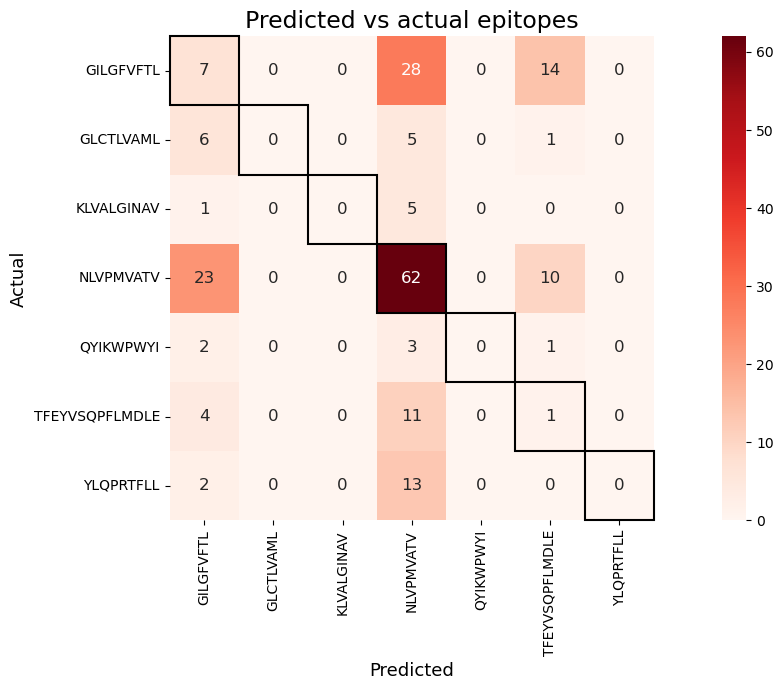

In [484]:
figure, axis = plt.subplots(nrows=1,figsize=(14,7))
sns.heatmap(metrics_holder['actual_vs_labeled_matrix'], annot=True, cmap='Reds', fmt='', square=True, annot_kws={"size": 12})
axis.set_xlabel('Predicted', fontsize=13)
axis.set_ylabel('Actual', fontsize=13)
axis.set_title('Predicted vs actual epitopes', fontsize=17)
for tick in axis.get_xticklabels():
        tick.set_rotation(90)


#Adding boxes to highlight when actual was same as predicted.
for epitopes in range(metrics_holder['actual_vs_labeled_matrix'].shape[0]):
    axis.add_patch(Rectangle((epitopes, epitopes), 1, 1, ec='black', fc='none', lw=1.5, clip_on=False))
plt.tight_layout()

# Plot of metrics for each epitope

Text(0.5, 1.0, 'Average accuracy: 0.352')

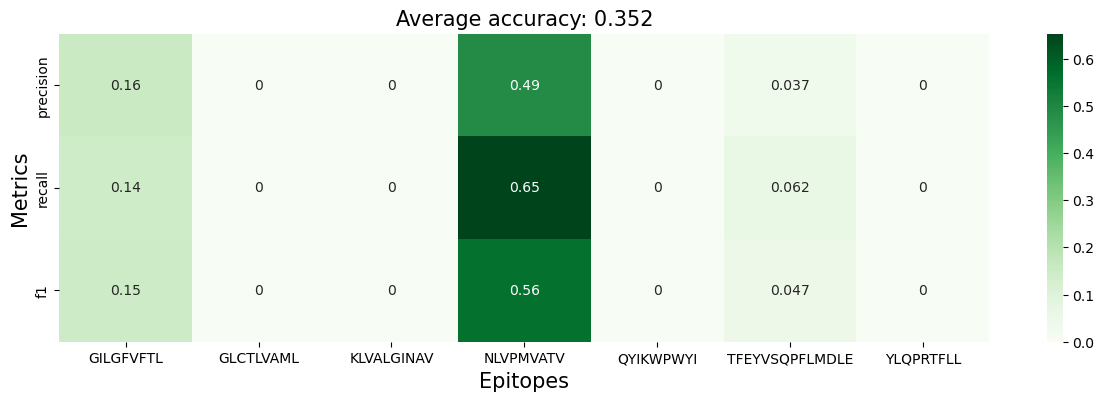

In [485]:
plt.figure(figsize=(15,4))
axis = sns.heatmap(metrics_table_df, annot=True, cmap='Greens' )
axis.set_ylabel('Metrics', fontsize=15)
axis.set_xlabel('Epitopes', fontsize=15)
axis.set_title(f"Average accuracy: {metrics_holder['accuracy']:.3f}", fontsize=15)
